# Course: AI in Era of Digital Transformation
# TOPIC: PREDICTING BIDV STOCK PRICE
- Student 1: Đoàn Nhật Hạ - 2115113067
- Student 2: Lê Thị Hoàng My - 2112153097
- Student 3: Phan Đình Phúc - 2114154015

In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import torch.optim as optim
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import MultiOutputMixin, RegressorMixin, BaseEstimator, _fit_context
from abc import ABCMeta, abstractmethod
from sklearn.utils.validation import check_is_fitted, _check_sample_weight
from sklearn.utils.extmath import safe_sparse_dot
from numbers import Integral


# Question 1

## Read data from file csv

In [37]:
stock_price_df = pd.read_csv('./stock_price.csv', index_col=False)
stock_price_df['<Date>'] = pd.to_datetime(stock_price_df['<Date>'])
stock_price_df = stock_price_df.sort_values(by='<Date>', ascending=True).set_index('<Date>')
stock_price_df.head()

,<Ticker>,<Open>,<High>,<Low>,<Close>,<Volume>
<Date>,,,,,,
2014-01-24,BID,14.4241,14.8037,14.0446,14.2723,8417060
2014-01-27,BID,14.1964,14.2723,13.7409,13.9686,3240910
2014-02-06,BID,13.8168,13.8927,13.3613,13.3613,959590
2014-02-07,BID,13.2095,13.2854,12.5262,12.6021,2987600
2014-02-10,BID,12.5262,13.0576,12.2984,12.9058,4052090


## Overview & EDA dataset

In [38]:
stock_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1847 entries, 2014-01-24 to 2021-06-25
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <Ticker>  1847 non-null   object 
 1   <Open>    1847 non-null   float64
 2   <High>    1847 non-null   float64
 3   <Low>     1847 non-null   float64
 4   <Close>   1847 non-null   float64
 5   <Volume>  1847 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 101.0+ KB


In [39]:
stock_price_df.isna().sum()

<Ticker>    0
<Open>      0
<High>      0
<Low>       0
<Close>     0
<Volume>    0
dtype: int64

In [40]:
stock_price_df.duplicated().sum()

0

In [41]:
stock_price_df.describe().T

,count,mean,std,min,25%,50%,75%,max
<Open>,1847.0,2.580522e+01,1.168290e+01,10.1164,15.24105,2.184560e+01,3.637285e+01,5.398760e+01
<High>,1847.0,2.620895e+01,1.187267e+01,10.1967,15.43810,2.227060e+01,3.703135e+01,5.487270e+01
<Low>,1847.0,2.544533e+01,1.150020e+01,10.0361,15.03770,2.162220e+01,3.569670e+01,5.290590e+01
<Close>,1847.0,2.582485e+01,1.167851e+01,10.1164,15.25500,2.193060e+01,3.644620e+01,5.457760e+01
<Volume>,1847.0,1.895362e+06,1.538950e+06,51430.0000,800655.00000,1.531780e+06,2.523570e+06,1.570104e+07


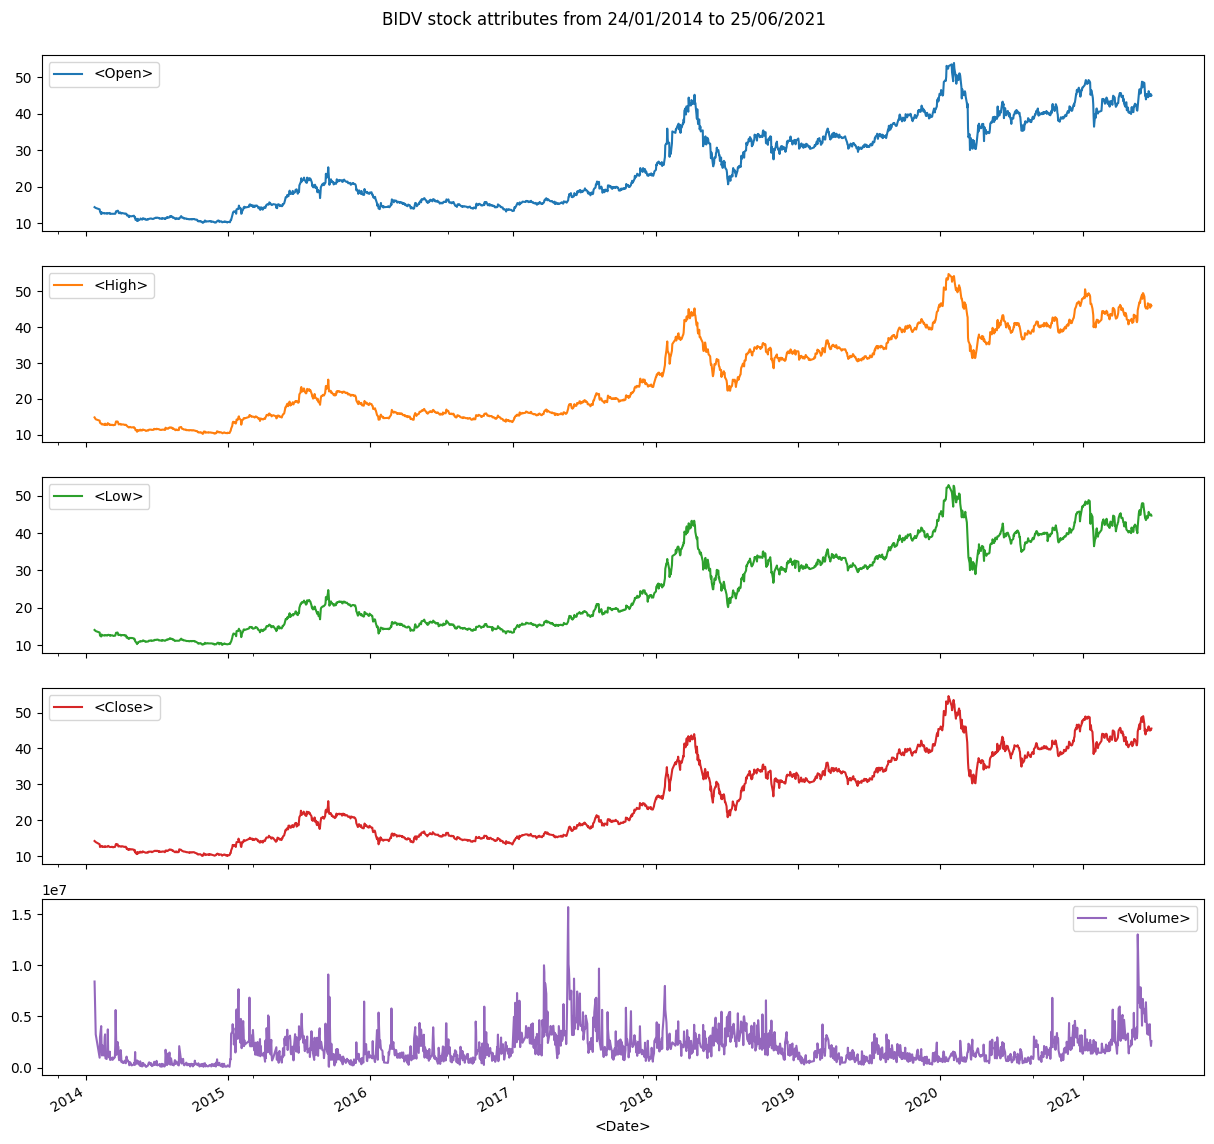

In [42]:
stock_price_df.plot(subplots=True, figsize=(15, 15))
plt.suptitle('BIDV stock attributes from 24/01/2014 to 25/06/2021', y=0.91)
plt.show()

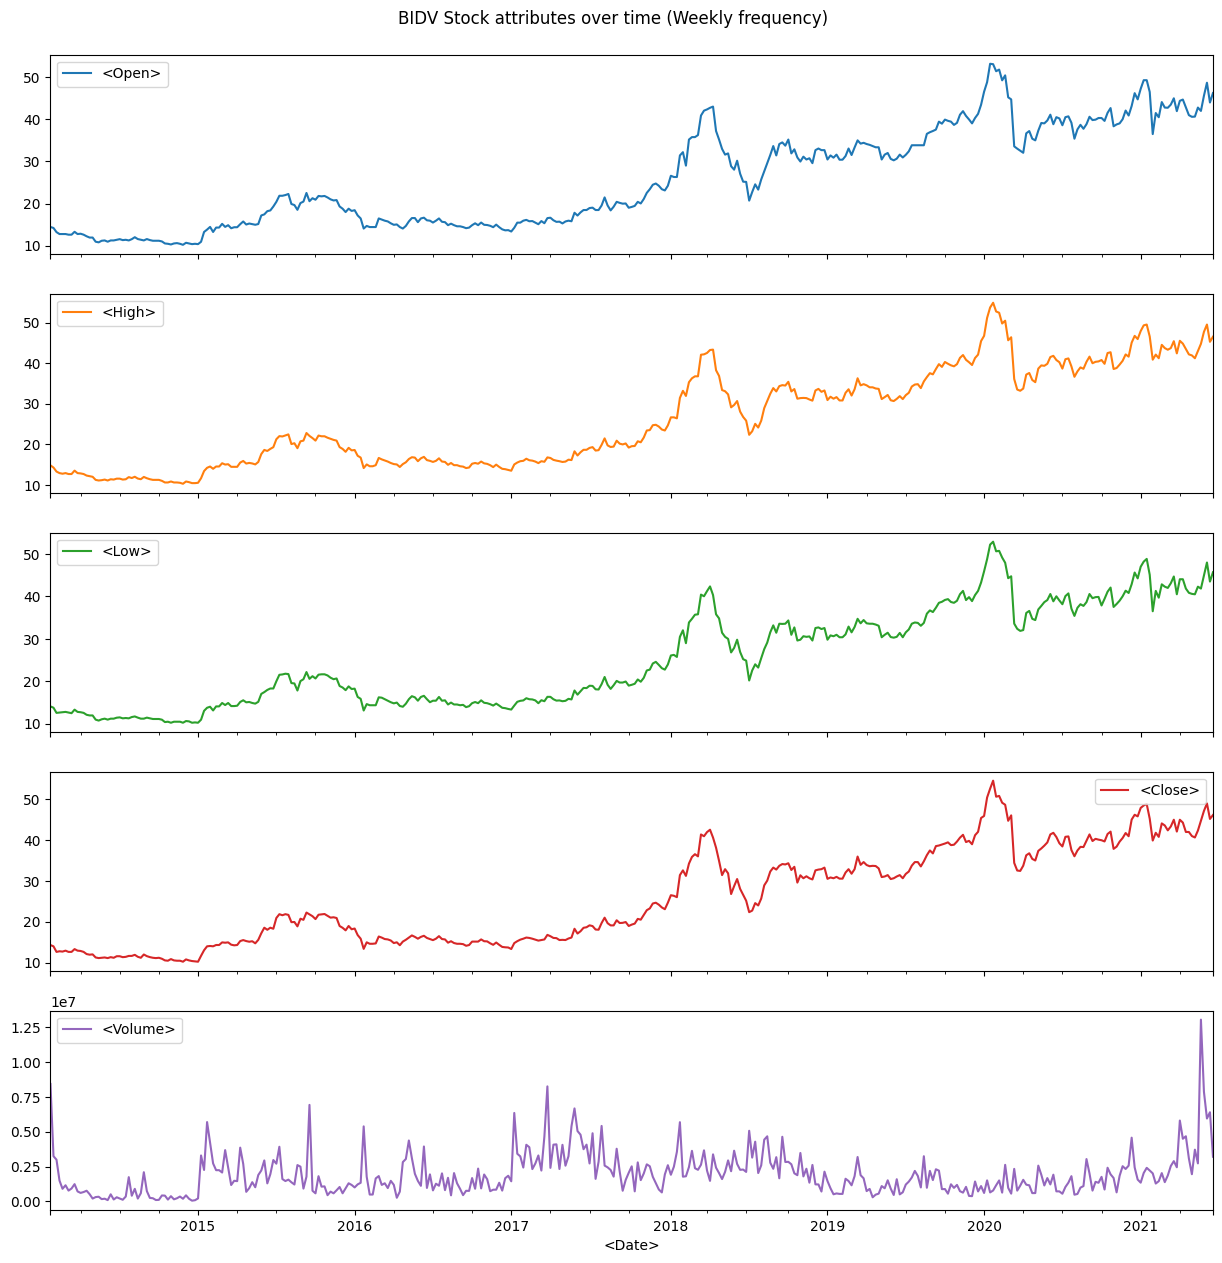

In [43]:
stock_price_df.asfreq('W', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('BIDV Stock attributes over time (Weekly frequency)', y=0.91)
plt.show()

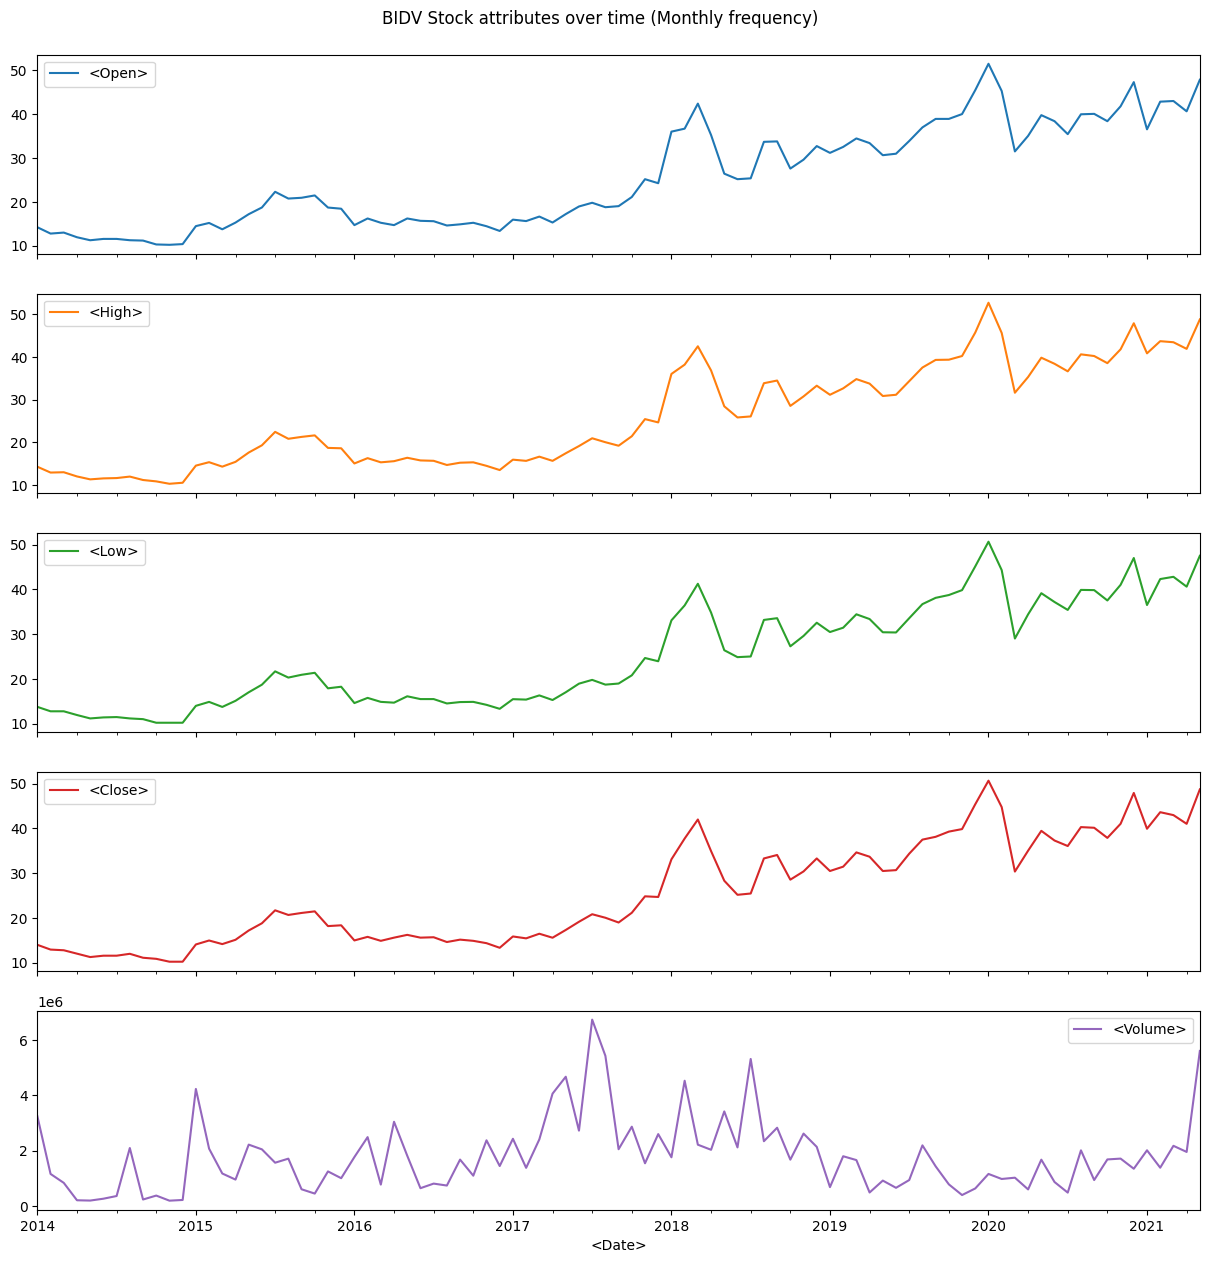

In [44]:
stock_price_df.asfreq('M', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('BIDV Stock attributes over time (Monthly frequency)', y=0.91)
plt.show()

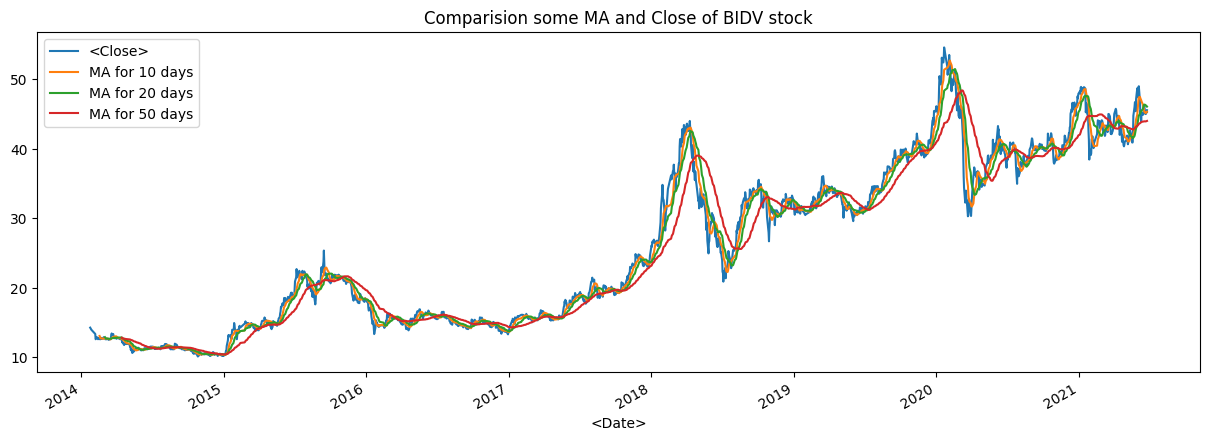

In [45]:
#computing moving average(ma)
ma_day = [10, 20, 50]

for ma in ma_day:
    col_name = f'MA for {ma} days'
    stock_price_df[col_name] = stock_price_df['<Close>'].rolling(ma).mean()

stock_price_df[['<Close>', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(figsize=(15,5))
plt.title('Comparision some MA and Close of BIDV stock')
plt.show()

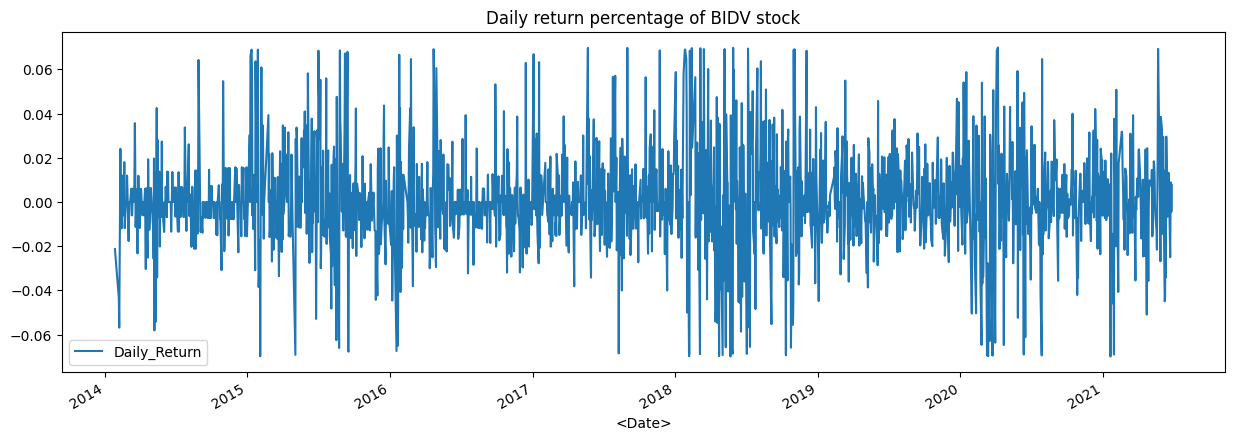

In [46]:
# use pct_change to find the percent change for each day
stock_price_df['Daily_Return'] = stock_price_df['<Close>'].pct_change()
# plot the daily return percentage
stock_price_df.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of BIDV stock')
plt.show()

# Question 2

## Preparing Dataset

In [47]:
# normalize data
df1 = stock_price_df.copy(deep=True)
scaler = MinMaxScaler(feature_range=(0,15)).fit(df1['<Low>'].values.reshape(-1,1))
df1['<Open>'] = scaler.transform(df1['<Open>'].values.reshape(-1,1))
df1['<High>'] = scaler.transform(df1['<High>'].values.reshape(-1,1))
df1['<Low>'] = scaler.transform(df1['<Low>'].values.reshape(-1,1))
df1['<Close>'] = scaler.transform(df1['<Close>'].values.reshape(-1,1))
data = df1[['<Open>','<High>','<Low>', '<Close>']].values
data.shape

(1847, 4)

In [48]:
seq_len=11
sequences=[]
for index in range(len(data) - seq_len + 1): 
    sequences.append(data[index: index + seq_len])
sequences= np.array(sequences)

In [49]:
test_set_size_percentage = 20 

test_set_size  = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - test_set_size

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]

x_test = sequences[train_set_size:,:-1,:]
y_test = sequences[train_set_size:,-1,:]

Create OLS model

In [50]:
class MultipleLinearRegression:
    def __init__(self):
        self.weights = []

    def flatten(self, X):
        X_flatten = []
        for idx in range(len(X)):
            X_flatten.append(X[idx].flatten())
        X_flatten = np.array(X_flatten)
        return X_flatten

    def _add_bias(self, X):
        one = np.ones((X.shape[0], 1))
        return np.concatenate((one, X), axis = 1)

    def fit(self, X, y):
        X = self.flatten(X)
        X = self._add_bias(X)
        self.output_dimension = y.shape[1]
        for idx in range(self.output_dimension):
            A = np.dot(X.T, X)
            b = np.dot(X.T, y)
            self.weights.append(np.dot(np.linalg.pinv(A), b)[:,0])
        self.weights = np.array(self.weights)

    def predict(self, X):
        X = self.flatten(X)
        X = self._add_bias(X)
        return self.weights.dot(X.T).T

In [51]:
model = MultipleLinearRegression()
model.fit(x_train, y_train)

Getting prediction on testset

In [52]:
y_test_pred = model.predict(x_test)

Metrics to evaluate

In [53]:
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
index = ['MSE', 'MAE', 'R2 score']
mlr_metric_df = pd.DataFrame([mse, mae, r2], columns=['<Open>','<High>','<Low>', '<Close>'], index=index)
mlr_metric_df

,<Open>,<High>,<Low>,<Close>
MSE,0.052794,0.112637,0.136472,0.133145
MAE,0.147009,0.258281,0.250232,0.262994
R2 score,0.978994,0.955699,0.943841,0.946423


Visualize predicted values

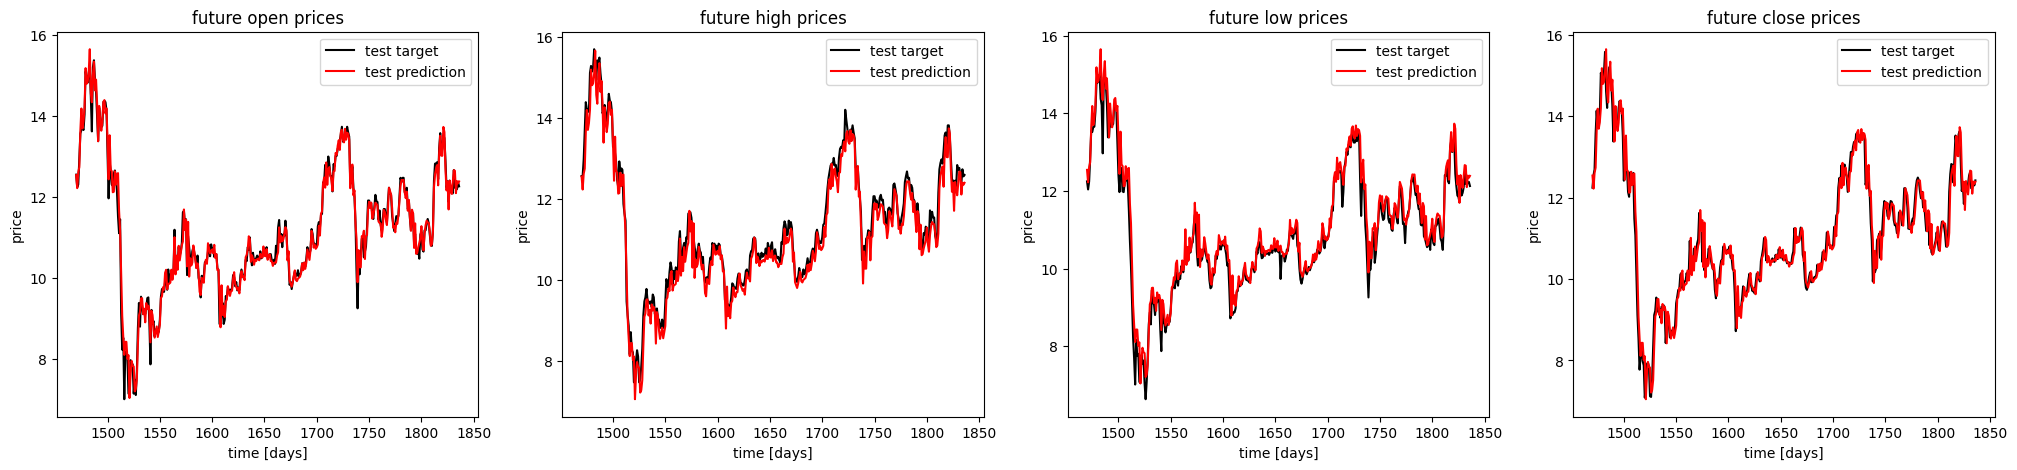

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_figwidth(25)
fig.set_figheight(5)
for i in range(4):
    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,i], color='black', label='test target')

    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,i], color='red', label='test prediction')

    ax[i].set_xlabel('time [days]')
    ax[i].set_ylabel('price')
    ax[i].legend(loc='best')

ax[0].set_title('future open prices')
ax[1].set_title('future high prices')
ax[2].set_title('future low prices')
ax[3].set_title('future close prices')

plt.show()

# Question 3

## Preparing Dataset

### Data Normalization:
This is an important pre-processing step for neural networks:

In [55]:
# normalize data
df2 = stock_price_df.copy(deep=True)
scaler = MinMaxScaler(feature_range=(0,15)).fit(df2['<Low>'].values.reshape(-1,1))
df2['<Open>'] = scaler.transform(df2['<Open>'].values.reshape(-1,1))
df2['<High>'] = scaler.transform(df2['<High>'].values.reshape(-1,1))
df2['<Low>'] = scaler.transform(df2['<Low>'].values.reshape(-1,1))
df2['<Close>'] = scaler.transform(df2['<Close>'].values.reshape(-1,1))
data = df2[['<Open>','<High>','<Low>', '<Close>']].values
data.shape

(1847, 4)

### Preparing Data for Time Series:
 In order to prepare the dataset for stock price prediction, we need to frame it as a time series problem. We will use the price from the previous 10 days to predict the price on the next day. Let’s create the sequences accordingly:

In [56]:
seq_len = 11
sequences = []
for index in range(len(data) - seq_len + 1): 
    sequences.append(data[index: index + seq_len])
sequences = np.array(sequences)

### Splitting the Data 
We divide the entire dataset into three parts. 80% for the training set, 10% for the validation set and the remaining 10% for the test set:

In [57]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

valid_set_size = int(np.round(valid_set_size_percentage/100*sequences.shape[0]))  
test_set_size  = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - (valid_set_size + test_set_size)

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]
    
x_valid = sequences[train_set_size:train_set_size+valid_set_size,:-1,:]
y_valid = sequences[train_set_size:train_set_size+valid_set_size,-1,:]
    
x_test = sequences[train_set_size+valid_set_size:,:-1,:]
y_test = sequences[train_set_size+valid_set_size:,-1,:]

## Build, Train & Test Models

### Model: Vanilla LSTM

##### Creating Data Loaders
Next, we define the data loaders to load the dataset in batches:

In [58]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

train_dataset = TensorDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

valid_dataset = TensorDataset(x_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

##### Defining Model Architecture 
We will define the model architecture. As it’s a time series problem, we will use Long Short-term Memory (LSTM) to capture the sequential information:

In [59]:
from torch import nn
class VanillaLSTM(nn.Module):
    def __init__(self, num_feature):
        super(VanillaLSTM, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = VanillaLSTM(4)

In [60]:
summary(model, (4, ))

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  17,920
├─Linear: 1-2                            [-1, 4]                   260
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07


Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  17,920
├─Linear: 1-2                            [-1, 4]                   260
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07

We also need to define the optimizer and loss:

In [61]:
optimizer = optim.Adam(model.parameters())
mse = nn.MSELoss()

##### Model Training 
First, we define the forward and backward pass for training the neural network:

In [62]:
def train(dataloader):
    epoch_loss = 0
    model.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y = batch
        pred = model(x)
        loss = mse(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

Now, let us define only the forward pass for evaluating the model performance:

In [63]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = mse(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

Let’s train the model for 1000 epochs. We will also save the best model during training based on the validation loss

In [64]:
n_epochs = 1000
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):

    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, './checkpoint/saved_weights.pt')

    if (epoch % 200 == 0):
        print(f'\tEpoch: {epoch} | ' + f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

	Epoch: 200 | 	Train Loss: 1.78948 | 	Val Loss: 0.36802

	Epoch: 400 | 	Train Loss: 2.28671 | 	Val Loss: 0.74667

	Epoch: 600 | 	Train Loss: 1.11609 | 	Val Loss: 0.25865

	Epoch: 800 | 	Train Loss: 0.89652 | 	Val Loss: 0.46759

	Epoch: 1000 | 	Train Loss: 0.98063 | 	Val Loss: 0.52847



##### Model Inference 
We are ready to make some predictions. First, we load the best model:

In [65]:
model=torch.load('./checkpoint/saved_weights.pt')

Let’s make predictions on the test set:

In [66]:
x_test = torch.tensor(x_test).float()

with torch.no_grad():
  y_test_pred = model(x_test)

y_test_pred = y_test_pred.numpy()[0]

Metrics to evaluate

In [67]:
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
index = ['MSE', 'MAE', 'R2 score']
vanilla_lstm_metric_df = pd.DataFrame([mse, mae, r2], columns=['<Open>','<High>','<Low>', '<Close>'], index=index)
vanilla_lstm_metric_df

,<Open>,<High>,<Low>,<Close>
MSE,0.047509,0.066623,0.085833,0.121249
MAE,0.161175,0.197067,0.221880,0.264245
R2 score,0.953450,0.935310,0.910602,0.878693


Finally, we visualize the predictions and compare them with the ground truth:

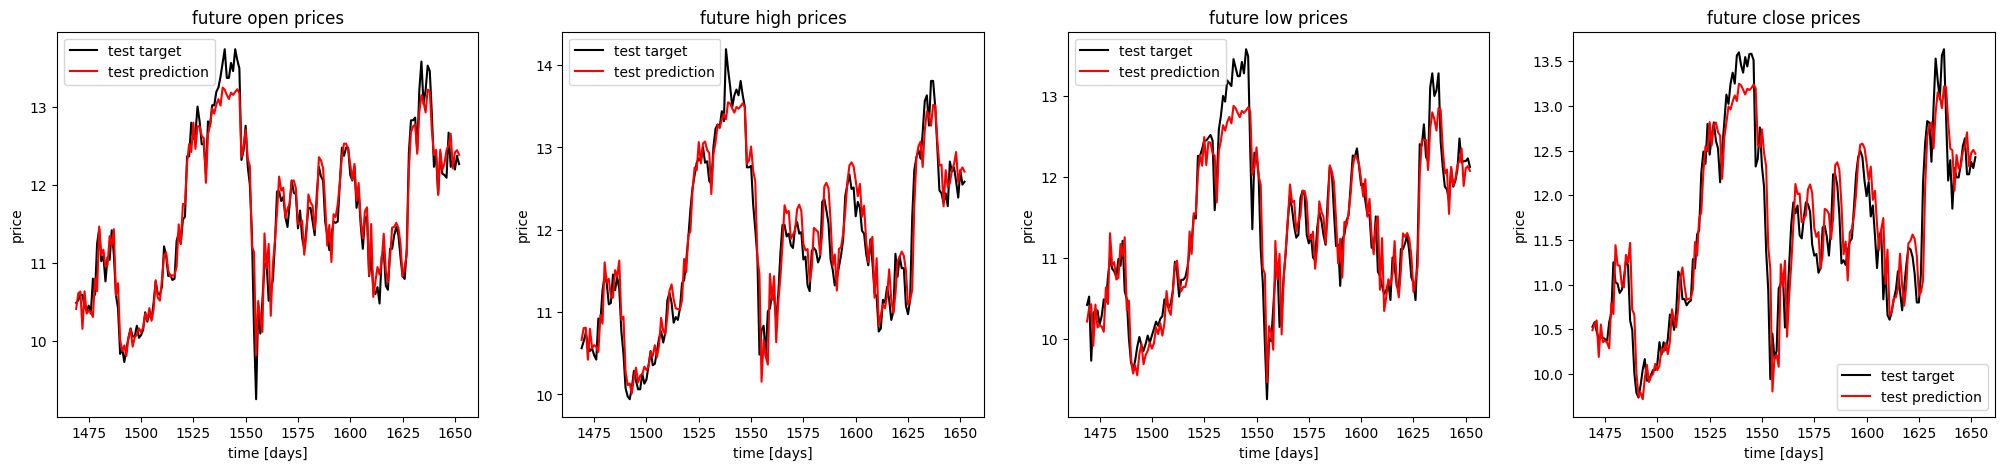

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_figwidth(25)
fig.set_figheight(5)
for i in range(4):
    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,i], color='black', label='test target')

    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,i], color='red', label='test prediction')

    ax[i].set_xlabel('time [days]')
    ax[i].set_ylabel('price')
    ax[i].legend(loc='best')

ax[0].set_title('future open prices')
ax[1].set_title('future high prices')
ax[2].set_title('future low prices')
ax[3].set_title('future close prices')

plt.show()

## Predict Next 10 Days

In [69]:
# Get the last sequence of historical data as features for predicting the next 10 days
last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions for the next 10 days
PRED_DAYS = 10
with torch.no_grad():
    for i in range(PRED_DAYS):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]


pred_days = last_sequence.reshape(PRED_DAYS, 4).numpy()

# inverse transform the predicted values
pred_days = scaler.inverse_transform(pred_days)

df_pred = pd.DataFrame(
    data=pred_days,
    columns=['<Open>', '<High>', '<Low>', '<Close>']
)

df_pred

,<Open>,<High>,<Low>,<Close>
0,45.666080,46.539597,44.770878,45.814682
1,45.866459,46.742294,44.978058,46.029224
2,46.067684,46.946022,45.162830,46.215450
3,46.185207,47.079929,45.265263,46.337807
4,46.274551,47.180214,45.340706,46.426174
5,46.332970,47.247700,45.389091,46.485626
6,46.370766,47.292660,45.419205,46.524525
7,46.398701,47.325073,45.441574,46.552475
8,46.418205,47.347549,45.457321,46.572044
9,46.432465,47.363609,45.468994,46.586143
